In [16]:
from Metrics import *
from Kernels import *
from Windows import *
from collections import defaultdict
from sklearn.datasets import make_moons, make_classification
from sklearn.neighbors import NearestNeighbors
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.nonparametric import smoothers_lowess
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cm = plt.cm.RdBu

In [17]:
class kNN:
    def __init__(self, 
                 k=1, 
                 kernel=RectangularKernel(), 
                 metric=MinkowskiMetric(2), 
                 h = NonFixedWindow(), 
                 priori_weights = None):
        self.k = k
        self.X = None
        self.y = None
        self.h = h
        self.kernel = kernel
        self.metric = metric
        self.priori_weights = priori_weights
        self.neigh = NearestNeighbors(n_neighbors=self.k, metric=str(self.metric), p=self.metric.additional(), algorithm='kd_tree')

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.neigh.fit(self.X)
        if self.priori_weights is None:
            self.priori_weights = np.ones(len(X))
    
    def predict(self, u: np.ndarray):
        dct: dict[tp.Any, np.float64] = self.predict_probs(u)
        return max(dct, key=dct.get)
    
    def predict_probs(self, u: np.ndarray):
        dct: dict[tp.Any, np.float64] = defaultdict(np.float64)
        dist, ind = self.find_nearest(u)
        for dst, i in zip(dist, ind):
            dct[self.y[i]] += self.priori_weights[i] * self.kernel(dst / self.h(self.metric, self.X[ind[-1]], u))
        return dct
    
    def find_nearest(self, u):
        distances, indexes = self.neigh.kneighbors(np.array([u])) if type(self.h) is NonFixedWindow else self.neigh.radius_neighbors(np.array([u]), radius=self.h.h)
        return distances[0], indexes[0]
        

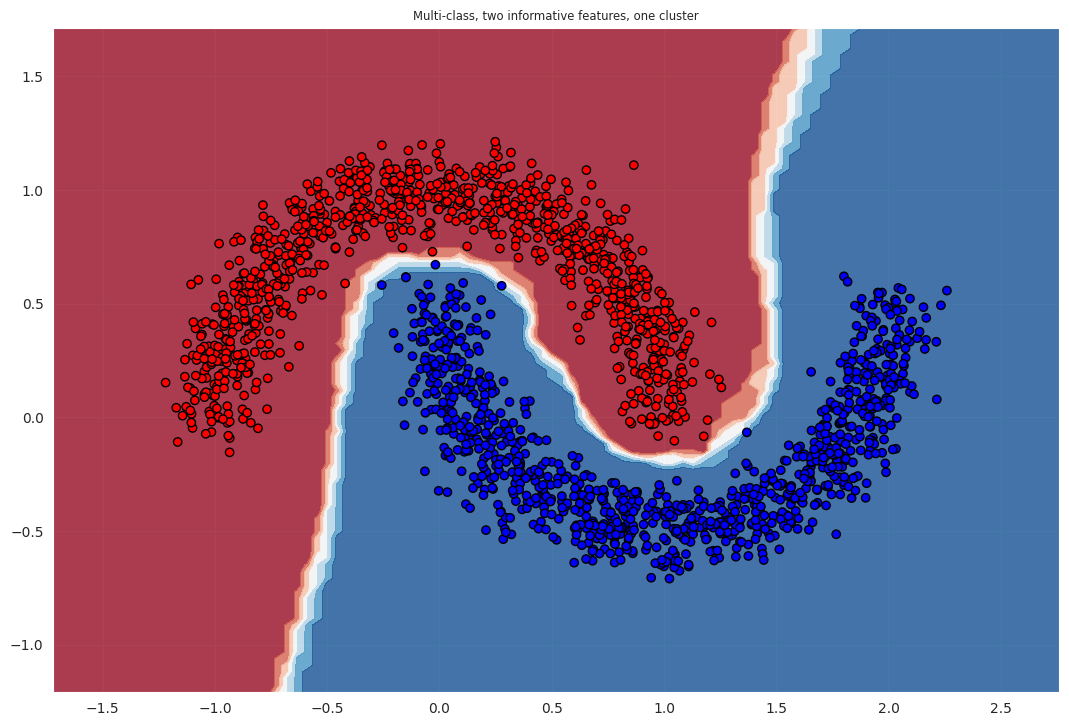

In [18]:
plt.figure(figsize=(21, 21))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
ax = plt.subplot(324)
plt.title("Multi-class, two informative features, one cluster",
          fontsize='small')
X1, Y1 = make_moons(n_samples=(1000, 1000), noise=0.1)
cls = KNeighborsClassifier();
# cls = kNN(k=5)
cls.fit(X1, Y1)
DecisionBoundaryDisplay.from_estimator(
    cls, X1, cmap=cm, alpha=0.8, ax=ax, eps=0.5
)
ax.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, cmap=cm_bright, edgecolors="k")
plt.tight_layout()
plt.show()

In [19]:
df = pd.read_csv('diabetes.csv')
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

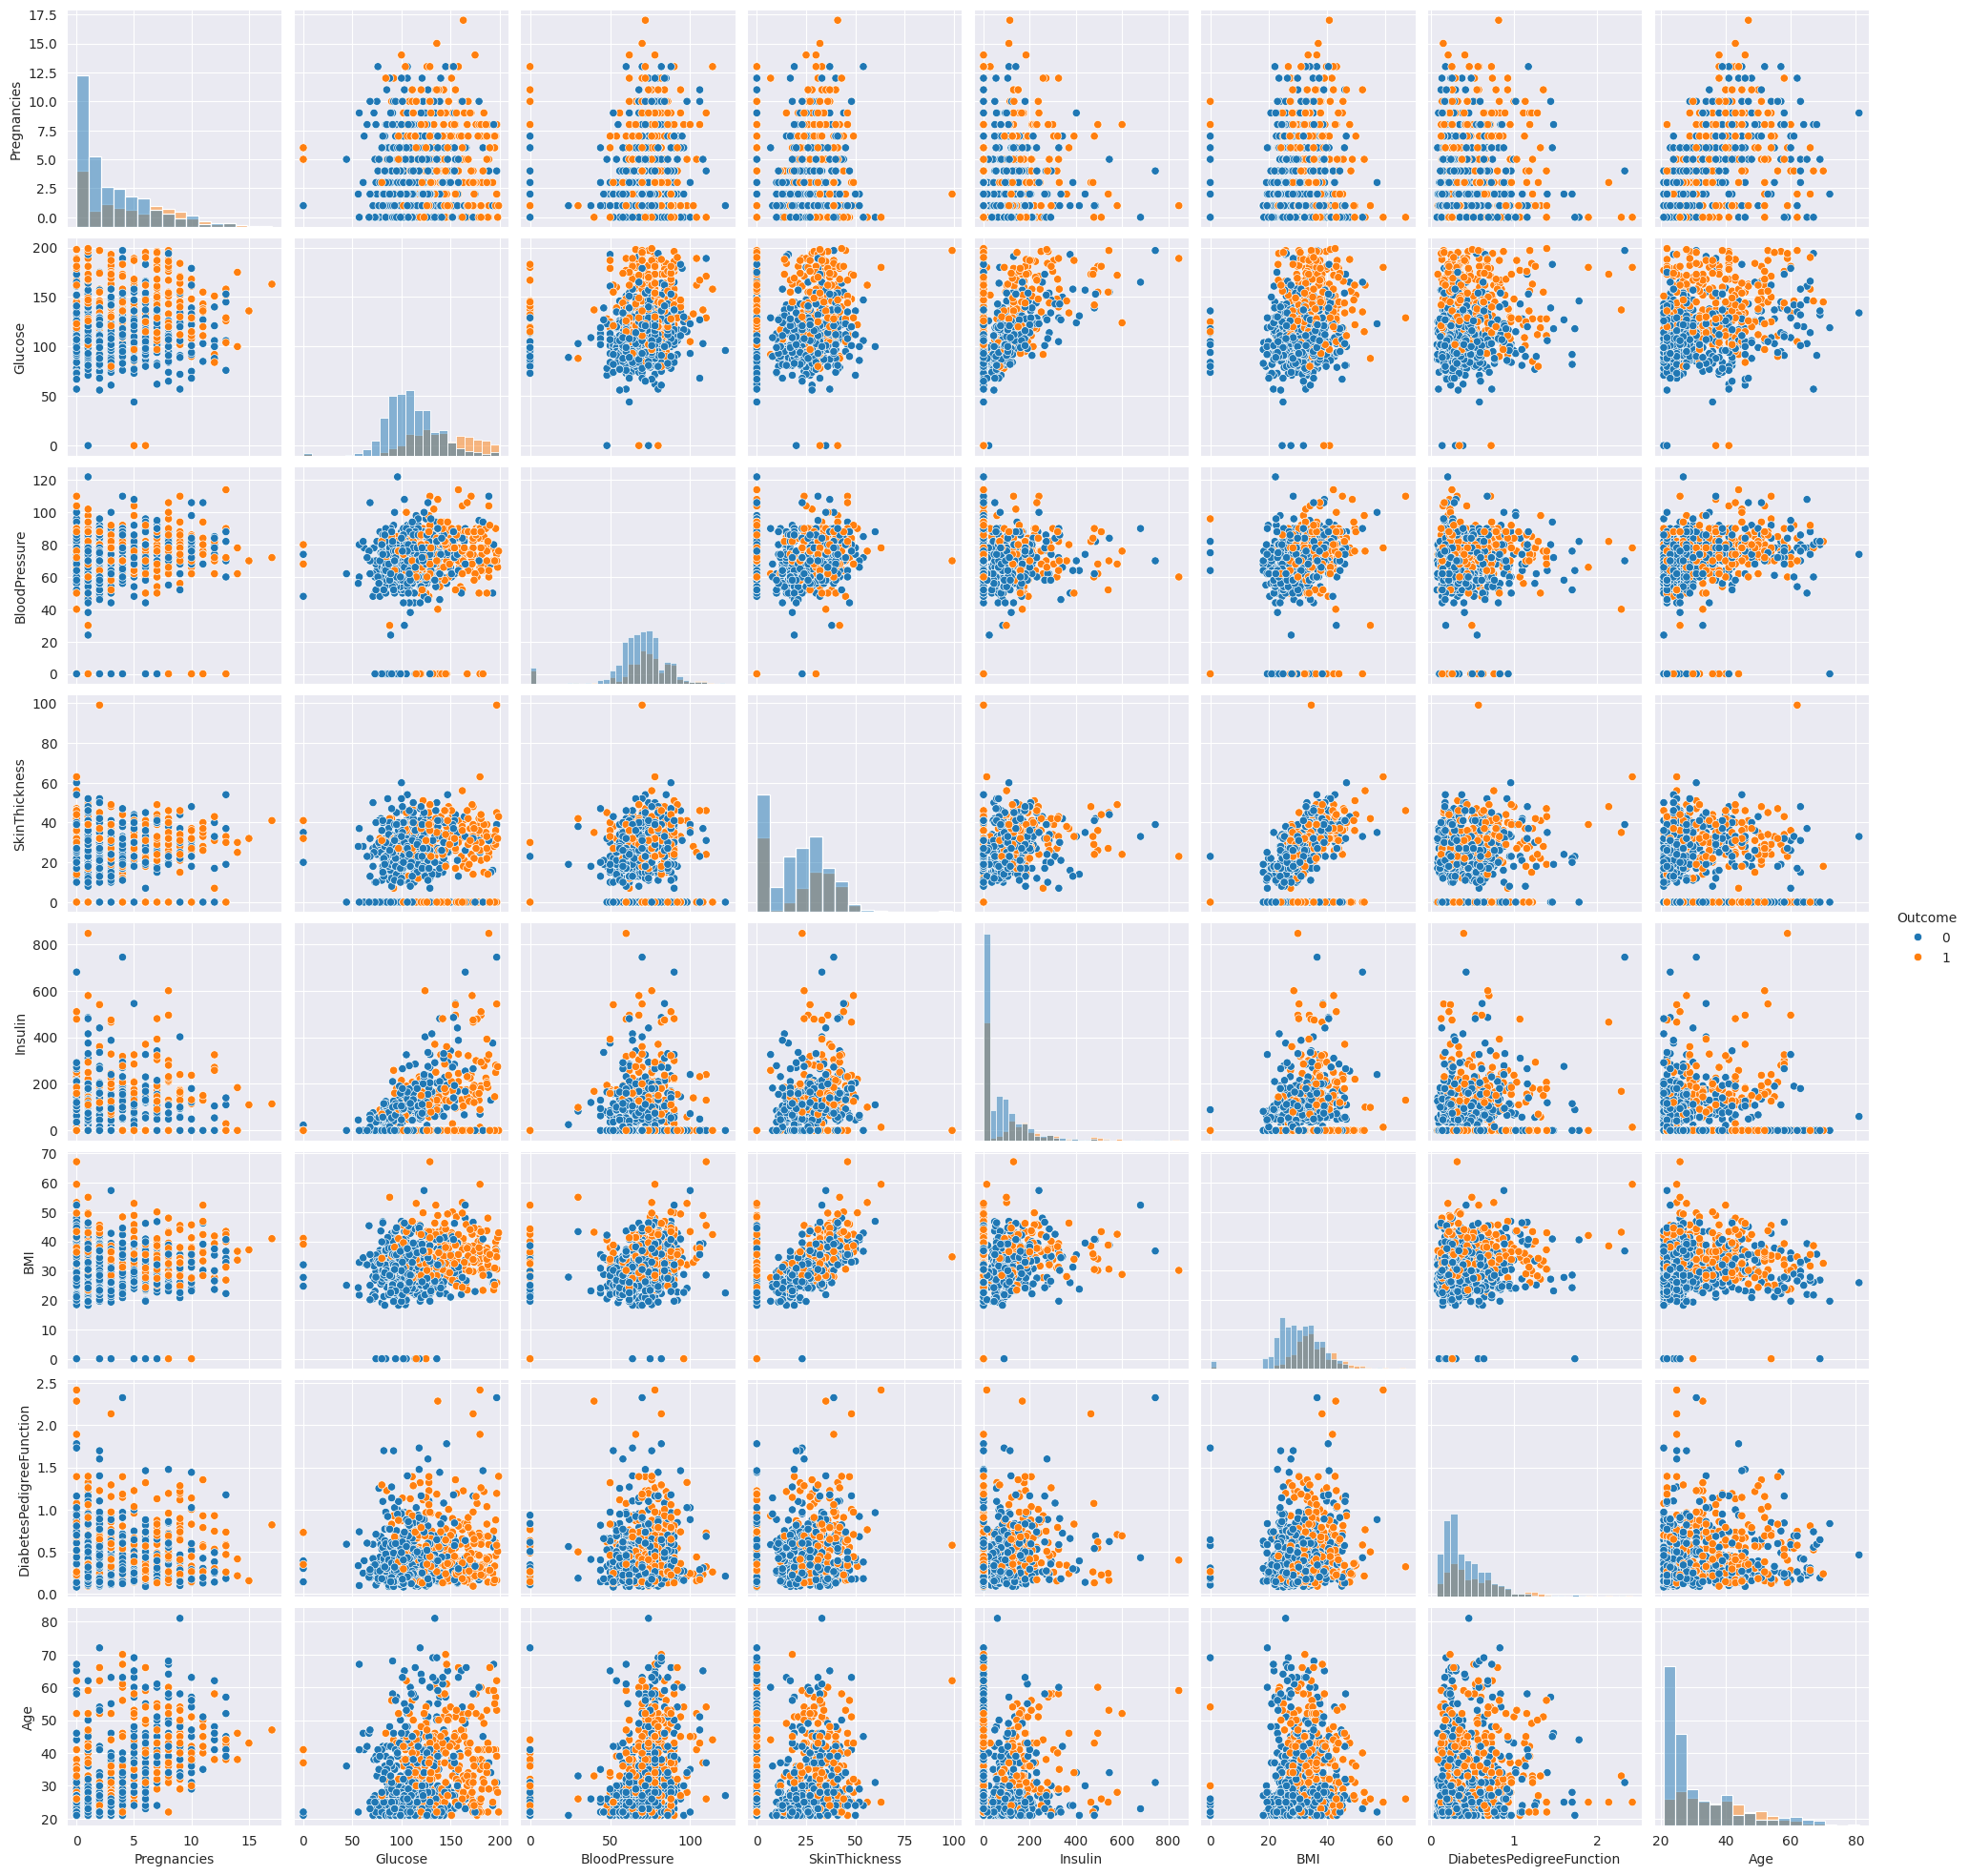

In [20]:
sns.pairplot(df, diag_kind='hist', hue='Outcome')

<Axes: >

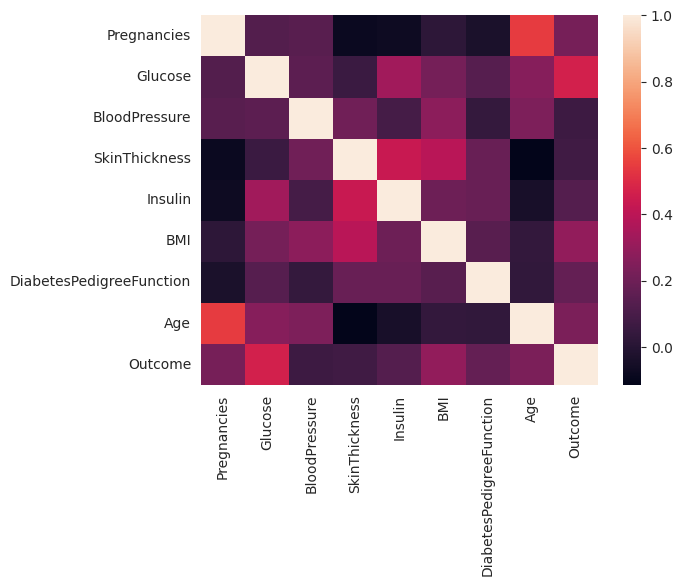

In [21]:
sns.heatmap(df.corr())

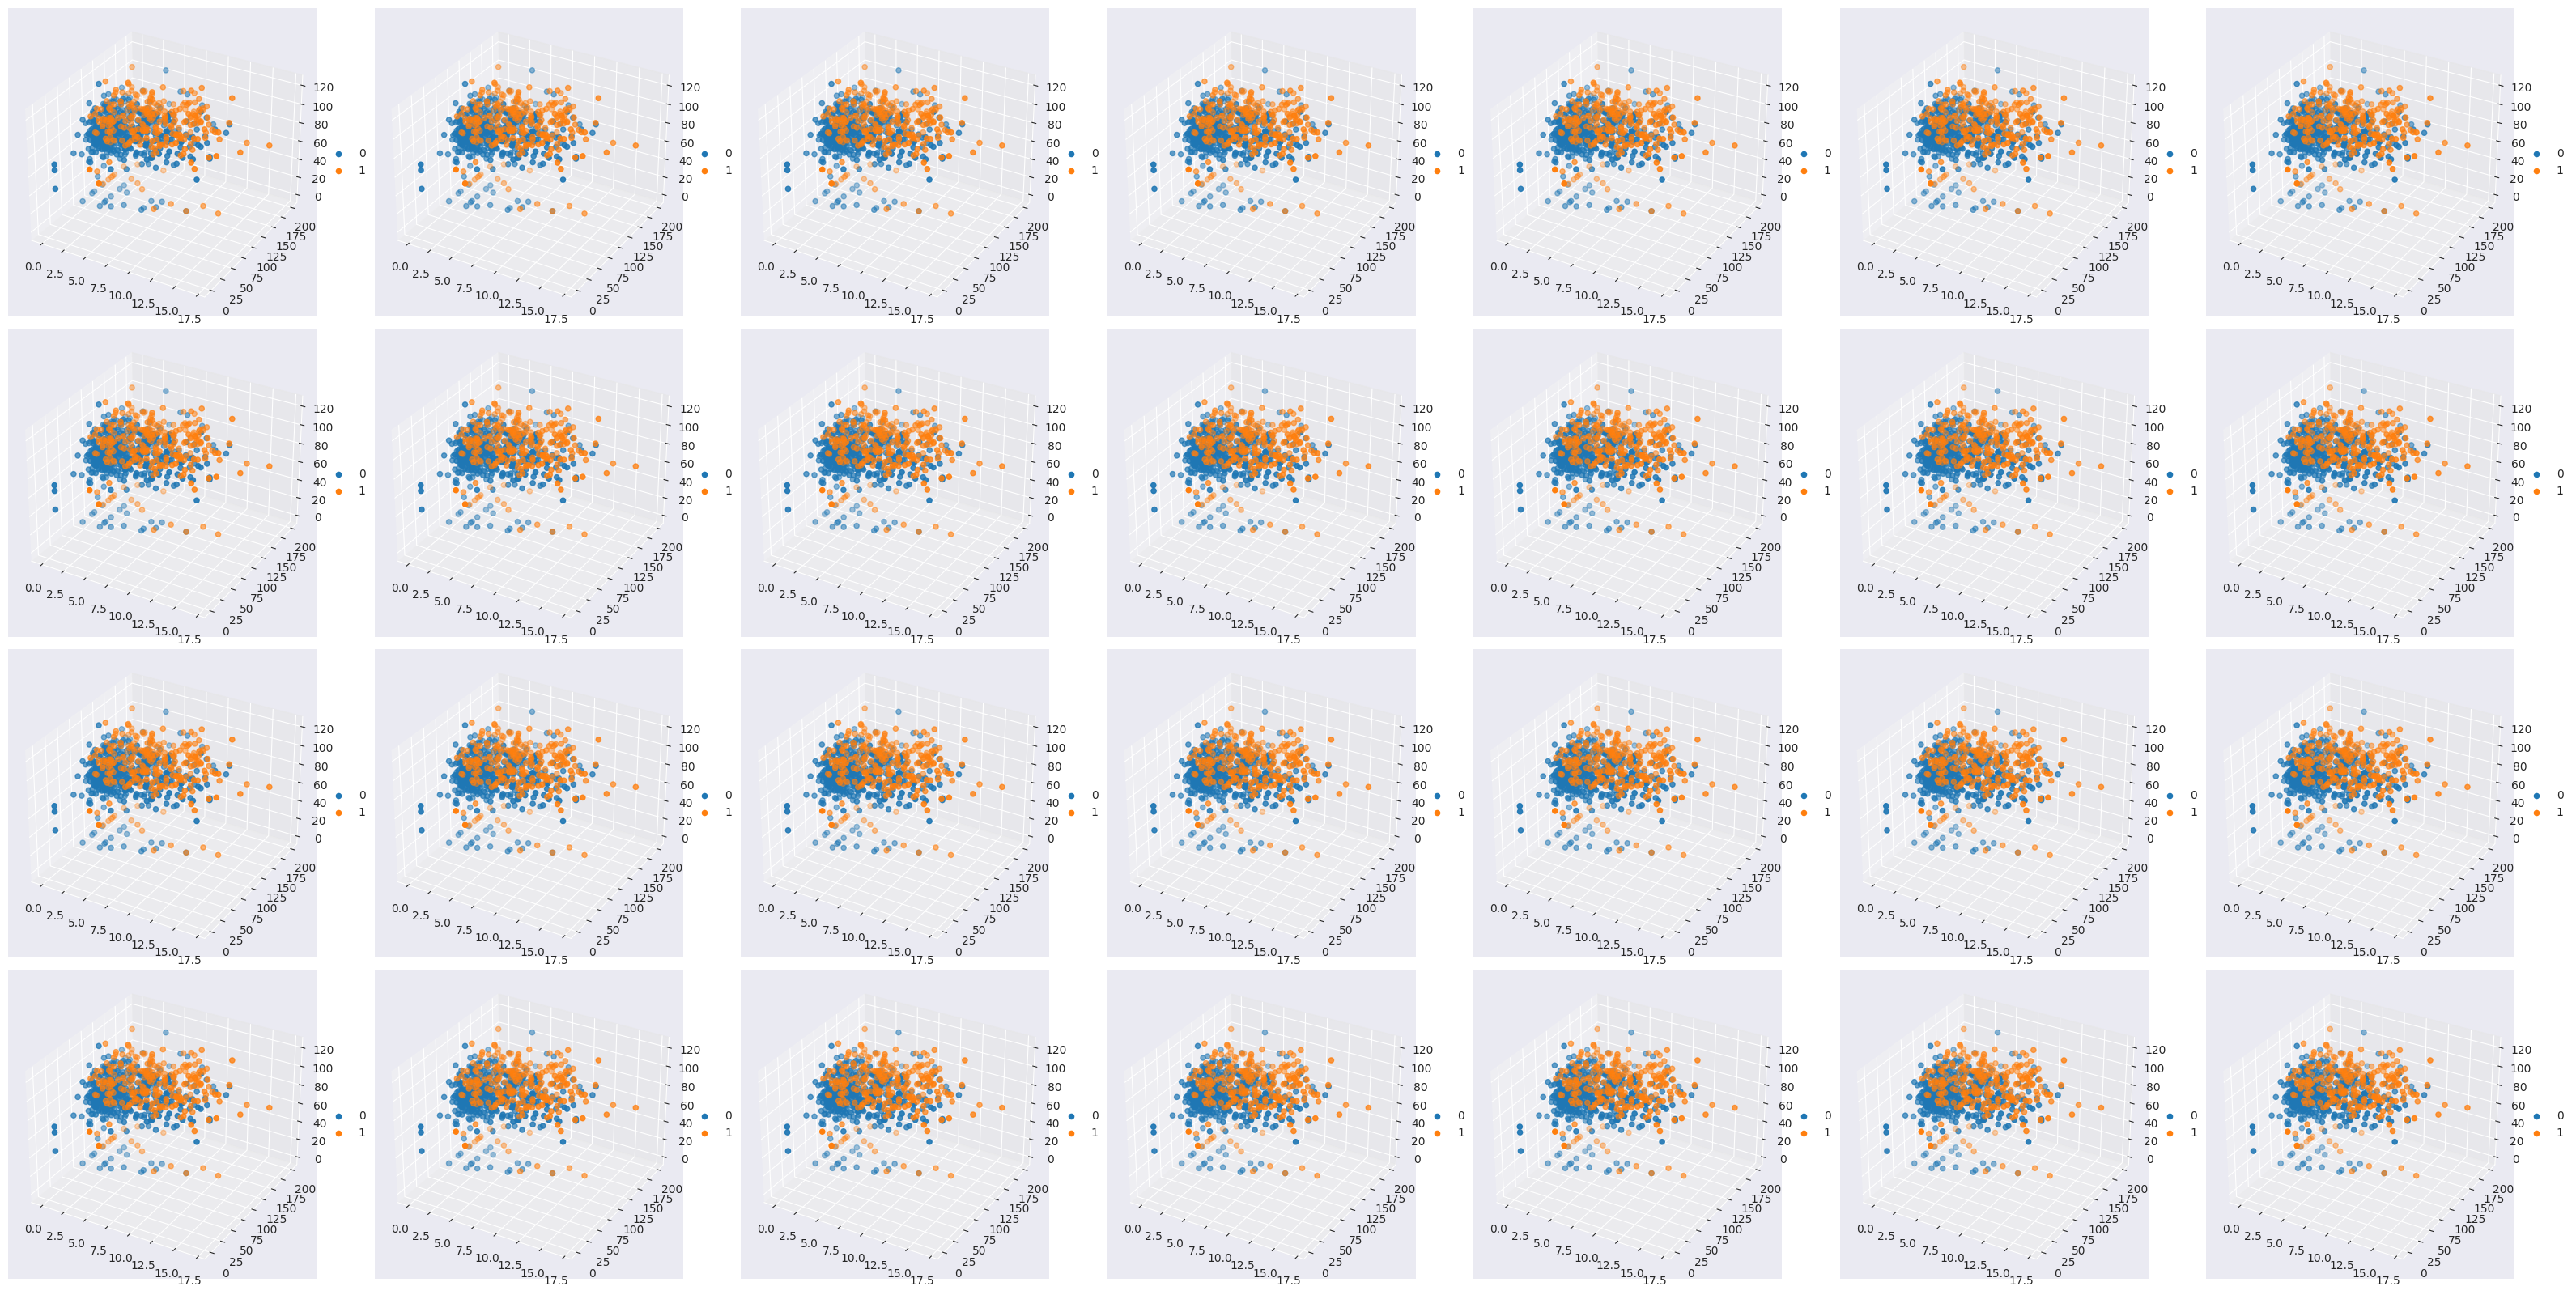

In [22]:
fig = plt.figure(figsize=(32, 16))
cnt = 1
for i in range(0, 8):
    for j in range(i + 1, 8):
        
        for grp_name, grp_idx in df.groupby(['Outcome']).groups.items():
            ax = plt.subplot(4, 7, cnt, projection='3d')
            ax.scatter(*df.iloc[grp_idx, [0,1,2]].T.values, label=grp_name)  # if you want to do everything in one line, lol
            ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
        cnt += 1
plt.tight_layout()
plt.show()

In [23]:
X, y = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy(), df[['Outcome']].to_numpy()
X_norm = (X - X.mean()) / X.std()
_X_train, X_test, _y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.2, random_state=42)
X_train

array([[-0.71926767,  1.42213437,  0.56557355, ..., -0.40919266,
        -0.76607015,  0.17155558],
       [-0.70213646,  0.85680423,  0.25721166, ..., -0.16421626,
        -0.76579606, -0.29098726],
       [-0.7535301 ,  2.02172694,  0.46278626, ..., -0.10254388,
        -0.74972697, -0.20533118],
       ...,
       [-0.73639889,  0.77114815,  0.39426139, ..., -0.11624886,
        -0.76204432, -0.30811848],
       [-0.68500524,  1.21655977,  0.49704869, ..., -0.21732303,
        -0.75935472, -0.17106875],
       [-0.70213646,  1.21655977,  0.46278626, ..., -0.39206144,
        -0.76272957, -0.13680632]])

In [24]:
len(X_val)

123

In [25]:
def fit_and_test(knn, test_X, test_y):
    FP = 0
    TP = 0
    FN = 0
    for x, y in zip(test_X, test_y):
        predict = knn.predict(x)
        if y == 1:
            if predict == 1:
                TP += 1
            else:
                FP += 1
        else:
            if predict == 1:
                FN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return precision, recall

In [26]:

def objective(trial):
    k = trial.suggest_int('k', 1, 121)
    knn = kNN(k=k,
          kernel=GaussianKernel(),
          priori_weights=None)
    knn.fit(X_train, np.transpose(y_train)[0])
    precision, recall = fit_and_test(knn, X_val, y_val)
    return 2 * precision * recall / (recall + precision)
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_value

[I 2024-04-09 15:20:07,212] A new study created in memory with name: no-name-b28020da-69fe-4e7a-87fe-744eb9a039bd
[I 2024-04-09 15:20:08,271] Trial 0 finished with value: 0.42857142857142855 and parameters: {'k': 107}. Best is trial 0 with value: 0.42857142857142855.
[I 2024-04-09 15:20:08,649] Trial 1 finished with value: 0.5277777777777778 and parameters: {'k': 33}. Best is trial 1 with value: 0.5277777777777778.
[I 2024-04-09 15:20:08,746] Trial 2 finished with value: 0.5952380952380952 and parameters: {'k': 5}. Best is trial 2 with value: 0.5952380952380952.
[I 2024-04-09 15:20:09,143] Trial 3 finished with value: 0.5555555555555556 and parameters: {'k': 35}. Best is trial 2 with value: 0.5952380952380952.
[I 2024-04-09 15:20:10,234] Trial 4 finished with value: 0.42857142857142855 and parameters: {'k': 111}. Best is trial 2 with value: 0.5952380952380952.
[I 2024-04-09 15:20:10,603] Trial 5 finished with value: 0.5555555555555556 and parameters: {'k': 34}. Best is trial 2 with val

0.64

In [27]:
print(study.best_params)

{'k': 11}


F-score: 0.616822429906542
Precision: 0.6
Recall: 0.6346153846153846


/tmp/ipykernel_66354/4163378530.py:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

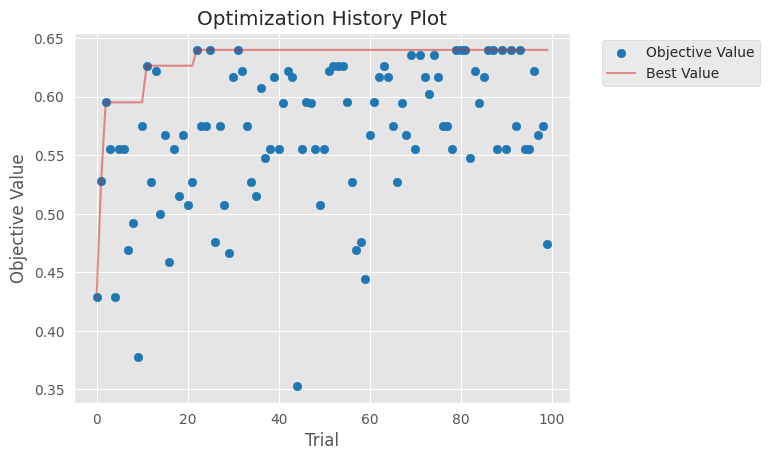

In [28]:
knn = kNN(k=study.best_params['k'],
          kernel=GaussianKernel(),
          priori_weights=None)
knn.fit(X_train, np.transpose(y_train)[0])
precision, recall = fit_and_test(knn, X_test, y_test)

print("F-score:", 2 * precision * recall / (recall + precision))
print("Precision:", precision)
print("Recall:", recall)
optuna.visualization.matplotlib.plot_optimization_history(study)

In [29]:
def objective(trial):
    k = trial.suggest_int('k', 1, 121)
    
    knn = KNeighborsClassifier(n_neighbors=k, weights=GaussianKernel(), algorithm='kd_tree')
    knn.fit(X_train, y_train)
    FP = 0
    TP = 0
    FN = 0
    for x, y in zip(X_val, y_val):
        predict = knn.predict(np.array([x]))
        if y == 1:
            if predict == 1:
                TP += 1
            else:
                FP += 1
        else:
            if predict == 1:
                FN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return 2 * precision * recall / (recall + precision)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_value

[I 2024-04-09 15:20:38,179] A new study created in memory with name: no-name-5583baf0-403f-4e83-a743-8fc542538ef0
/home/dis3e/PycharmProjects/lab1-knn-diS3e/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
[I 2024-04-09 15:20:38,250] Trial 0 finished with value: 0.5373134328358209 and parameters: {'k': 48}. Best is trial 0 with value: 0.5373134328358209.
/home/dis3e/PycharmProjects/lab1-knn-diS3e/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
[I 2024-04-09 15:20:38,320] Trial 1 finished with value: 0.5454545454545454 and parameters: {'k': 54}. Best is trial 1 with value: 0.5454

0.64

In [30]:
study.best_params

{'k': 11}

/tmp/ipykernel_66354/2999160266.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

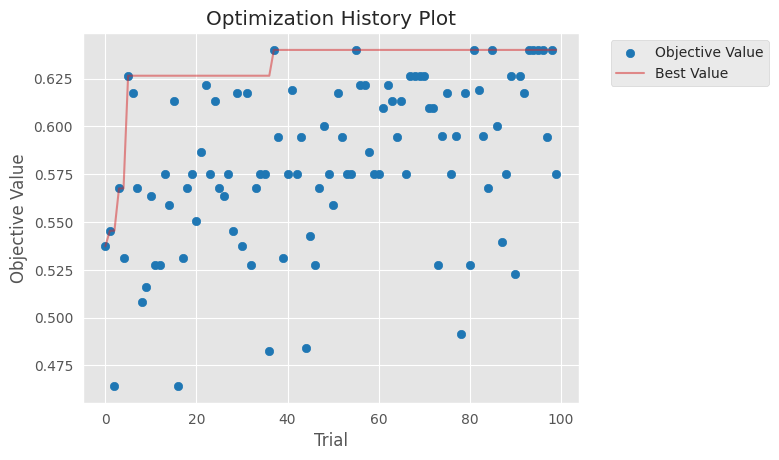

In [31]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [32]:
def lowess(X, y):
    return smoothers_lowess.lowess(y, X)

In [33]:
x = sorted(np.random.uniform(low = -4*np.pi, high = 4*np.pi, size=500))
y = np.sin(x) + np.random.normal(size=len(x))
z = smoothers_lowess.lowess(y, x)
w = smoothers_lowess.lowess(y, x, frac=1./3)

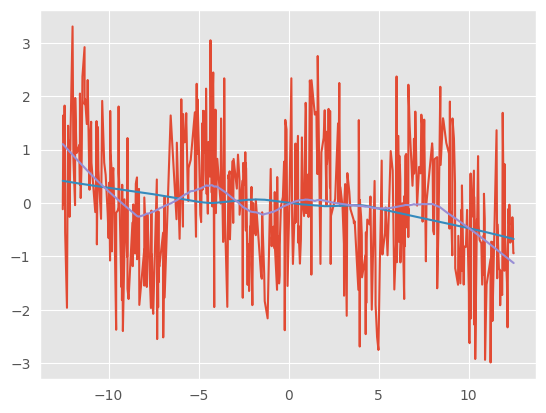

In [34]:
plt.plot(x, y)
plt.plot(z[..., 0], z[..., 1])
plt.plot(w[..., 0], w[..., 1])

In [35]:
K = GaussianKernel()
w = np.zeros(len(X_train))
# anomalies1 = []
# anomalies2 = []
weights = []
for i, x in enumerate(X_train):
    knn = kNN(k=11, kernel=GaussianKernel(), metric=MinkowskiMetric(2))
    knn.fit(np.delete(X_train, i, 0), np.delete(y_train, i))
    predict = knn.predict_probs(x)
    weights.append(K(predict[max(predict, key=predict.get)]))
    
    # w[i] = K(y_train[i][0] - predict)
    # if y_train[i][0] != predict:
    #     if predict == 1:
    #         anomalies1.append(i)
    #     else:
    #         anomalies2.append(i)
# print("Type 1 error:", len(anomalies1))
# print("Type 2 error:", len(anomalies2))

In [36]:
knn = kNN(k=11, kernel=GaussianKernel(), priori_weights=weights)
knn.fit(X_train, np.transpose(y_train)[0])
prec, rec = fit_and_test(knn, X_test, np.transpose(y_test)[0])
print(prec, rec, 2 * prec * rec / (prec + rec))

0.6181818181818182 0.6181818181818182 0.6181818181818182


In [44]:
print(weights)
print(min(weights))

[0.09731832572718593, 0.01931646626800057, 0.010087763877709469, 0.08289031628075266, 0.10891141371351838, 0.02977359598717915, 0.028340677895552006, 0.019328676005298594, 0.009578466821200903, 0.016762931034108502, 0.009835503079762092, 0.01050515953709739, 0.002366257337127999, 0.0036563821293689987, 0.011642325431475914, 0.02835814894803624, 0.0052133790643290635, 0.03420113495447556, 0.024352154295825174, 0.07117269042337979, 0.011072427827467158, 0.0076314912466178475, 0.01865134508478051, 0.043234729643981014, 0.024484972679717165, 0.014836522997784133, 0.02050845776874394, 0.007480215704479296, 0.05744737197892522, 0.025596163364933155, 0.009956622364191184, 0.05644162749183844, 0.007421800607740926, 0.009800008039032497, 0.08886176514782324, 0.005307003273325052, 0.007378479599956451, 0.08114276576420654, 0.08508502691628343, 0.008123413483134629, 0.0976696539362025, 0.00318184924857443, 0.004865755409769603, 0.002351664619368975, 0.07613830578059656, 0.0049521229322409925, 0.0

In [45]:
def objective(trial):
    n = trial.suggest_int('n', 100, 500)
    knn = KNeighborsClassifier(n_neighbors=n, weights=GaussianKernel(), algorithm='kd_tree')
    knn.fit(
        pd.DataFrame(X_train).sample(n=int(np.sum(weights) * n), weights=weights, random_state=239, replace=True),
        pd.DataFrame(y_train).sample(n=int(np.sum(weights) * n), weights=weights, random_state=239, replace=True)
    )
    FP = 0
    TP = 0
    FN = 0
    for x, y in zip(X_train, y_train):
        predict = knn.predict(np.array([x]))
        if y == 1:
            if predict == 1:
                TP += 1
            else:
                FP += 1
        else:
            if predict == 1:
                FN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return 2 * precision * recall / (precision + recall)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_value

[I 2024-04-09 15:38:24,455] A new study created in memory with name: no-name-5cc4497b-49b5-46ee-b318-568d07988f0d
/home/dis3e/PycharmProjects/lab1-knn-diS3e/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
[I 2024-04-09 15:38:24,944] Trial 0 finished with value: 0.6566265060240963 and parameters: {'n': 124}. Best is trial 0 with value: 0.6566265060240963.
/home/dis3e/PycharmProjects/lab1-knn-diS3e/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
[I 2024-04-09 15:38:25,411] Trial 1 finished with value: 0.6545454545454544 and parameters: {'n': 208}. Best is trial 0 with value: 0.65

0.6666666666666666

In [42]:
# type(FixedWindow(1)) is NonFixedWindow
study.best_params

{'n': 123}